In [1]:
from typing import Union
import h5py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def plot_mean_bond_dimensions(file_path: str, save_path: Union[str, None] = None):
    """
    Plots the mean virtual bond dimensions across different methods.

    Args:
        file_path (str): Path to the HDF5 file.
        save_path (Union[str, None]): If provided, saves the plot to this path.
    """
    methods = ["svd_bond_dim", "sge_bond_dim","bipartite_bond_dim", "basic_bond_dim"]
    mean_bond_dims = {method: [] for method in methods}
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"

            for i,method in enumerate(methods):
                dataset = file[group_name][method]
                # Step 1: Mean over bonds (axis=1), resulting in shape (num_runs,)
                mean_per_run = np.mean(dataset, axis=1)
                # Step 2: Mean over runs
                overall_mean = np.mean(mean_per_run)
                mean_bond_dims[method].append(overall_mean-i*0.2)

    # Plotting
    plt.figure(figsize=(8, 6))
    
    for i, method in enumerate(methods):
        label = method.replace("_bond_dim", "").capitalize()
        if len(label) == 3:
            label = label.upper()
        if label == "SGE":
            label = "SGE [Ours]"
        plt.plot(num_terms_list, mean_bond_dims[method], label=label, linestyle="-")

    plt.xlabel("Number of Terms", fontsize=20)
    plt.ylabel("Mean Virtual Bond Dimension", fontsize=20)
    plt.title("Mean Virtual Bond Dimensions Across Methods", fontsize=24)
    plt.legend(title="Methods", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()

In [3]:
def compare_and_plot_bond_dimensions(file_path: str, threshold: float = 1e-6, save_path: Union[str, None] = None):
    """
    Compares the mean bond dimensions across methods and identifies near-identical lines.

    Args:
        file_path (str): Path to the HDF5 file.
        threshold (float): The threshold to consider two lines as identical.
        save_path (Union[str, None]): If provided, saves the plot to this path.
    """
    methods = ["svd_bond_dim", "sge_bond_dim", "bipartite_bond_dim"]
    mean_bond_dims = {method: [] for method in methods}
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"

            for method in methods:
                dataset = file[group_name][method]
                # Step 1: Mean over bonds (axis=1), resulting in shape (num_runs,)
                mean_per_run = np.mean(dataset, axis=1)
                # Step 2: Mean over runs
                overall_mean = np.mean(mean_per_run)
                mean_bond_dims[method].append(overall_mean)

    # Calculate pairwise differences
    similarities = {}
    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if j > i:  # Avoid redundant comparisons
                diff = np.abs(np.array(mean_bond_dims[method1]) - np.array(mean_bond_dims[method2]))
                is_similar = np.all(diff < threshold)
                similarities[f"{method1} vs {method2}"] = is_similar

    # Print results of similarity check
    print("Comparison of methods:")
    for pair, similar in similarities.items():
        status = "Identical" if similar else "Different"
        print(f"{pair}: {status}")

    # Plotting
    plt.figure(figsize=(8, 6))
    for method in methods:
        plt.plot(num_terms_list, mean_bond_dims[method], label=method.replace("_bond_dim", "").capitalize())

    plt.xlabel("Number of Terms")
    plt.ylabel("Mean Virtual Bond Dimension")
    plt.title("Mean Virtual Bond Dimensions Across Methods")
    plt.legend(title="Methods")
    plt.grid(True)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()

In [4]:
def highlight_differences(file_path: str, save_path: Union[str, None] = None):
    """
    Highlights differences in mean bond dimensions by adding a difference plot.

    Args:
        file_path (str): Path to the HDF5 file.
        save_path (Union[str, None]): If provided, saves the plots to this path.
    """
    methods = ["svd_bond_dim", "sge_bond_dim", "bipartite_bond_dim"]
    mean_bond_dims = {method: [] for method in methods}
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"

            for method in methods:
                dataset = file[group_name][method]
                # Step 1: Mean over bonds (axis=1), resulting in shape (num_runs,)
                mean_per_run = np.mean(dataset, axis=1)
                # Step 2: Mean over runs
                overall_mean = np.mean(mean_per_run)
                mean_bond_dims[method].append(overall_mean)

    # Plot the main graph
    plt.figure(figsize=(8, 6)) 
    for method in methods:
        plt.plot(num_terms_list, mean_bond_dims[method], label=method.replace("_bond_dim", "").capitalize())
    plt.xlabel("Number of Terms")
    plt.ylabel("Mean Virtual Bond Dimension")
    plt.title("Mean Virtual Bond Dimensions Across Methods")
    plt.legend(title="Methods")
    plt.grid(True)
    if save_path:
        plt.savefig(save_path.replace(".pdf", "_main.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

    # Plot the difference graph
    plt.figure(figsize=(8, 6))
    markers = ['o', 's', '^', 'd', '<','*','P']  # Define distinct markers
    marker_id = 0
    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if j > i:  # Avoid redundant comparisons
                diff = np.abs(np.array(mean_bond_dims[method1]) - np.array(mean_bond_dims[method2]))
                plt.plot(num_terms_list, diff, label=f"{method1.replace('_bond_dim', '').capitalize()} - {method2.replace('_bond_dim', '').capitalize()}",marker=markers[marker_id])
                marker_id += 1

    
        
    plt.xlabel("Number of Terms", fontsize=18)
    plt.ylabel("Difference in Mean Virtual Bond Dimensions", fontsize=18)
    plt.title("Differences Between Methods", fontsize=20)
    plt.legend(title="Method Pair", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    if save_path:
        plt.savefig(save_path.replace(".pdf", "_differences.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

In [5]:
def plot_bond_dimension_distribution(file_path: str, plot_type: str = "box", save_path: Union[str, None] = None):
    """
    Plots the distribution of bond dimensions across methods for each number of terms.

    Args:
        file_path (str): Path to the HDF5 file.
        plot_type (str): Type of plot ("box" or "violin").
        save_path (Union[str, None]): If provided, saves the plot to this path.
    """
    methods = ["svd_bond_dim", "sge_bond_dim", "bipartite_bond_dim"]
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30
    data = []  # Collects all data for plotting

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"

            for method in methods:
                dataset = file[group_name][method][...]  # Load all bond dimensions
                for run_dims in dataset:  # Iterate over runs
                    for bond_dim in run_dims:  # Iterate over bonds
                        data.append({
                            "Number of Terms": num_terms,
                            "Bond Dimension": bond_dim,
                            "Method": method.replace("_bond_dim", "").capitalize()
                        })

    # Convert data to a structured format (e.g., for seaborn)
    df = pd.DataFrame(data)

    # Create the plot
    plt.figure(figsize=(16, 12))
    if plot_type == "box":
        sns.boxplot(x="Number of Terms", y="Bond Dimension", hue="Method", data=df, showfliers=True)
    elif plot_type == "violin":
        sns.violinplot(x="Number of Terms", y="Bond Dimension", hue="Method", data=df, split=True)

    plt.xlabel("Number of Terms in the Hamiltonian")
    plt.ylabel("Virtual Bond Dimension")
    plt.title("Distribution of Bond Dimensions Across Methods")
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()


In [6]:
def plot_average_bond_dimension_distribution(file_path: str, plot_type: str = "box", save_path: Union[str, None] = None):
    """
    Plots the distribution of average bond dimensions across methods for each number of terms.

    Args:
        file_path (str): Path to the HDF5 file.
        plot_type (str): Type of plot ("box" or "violin").
        save_path (Union[str, None]): If provided, saves the plot to this path.
    """
    methods = ["svd_bond_dim", "sge_bond_dim", "bipartite_bond_dim"]
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30
    data = []  # Collects all data for plotting

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"

            for method in methods:
                dataset = file[group_name][method][...]  # Load all bond dimensions
                # Step 1: Calculate the average across bonds for each run
                avg_bond_per_run = np.mean(dataset, axis=1)  # Shape: (num_runs,)
                # Step 2: Append the data
                for avg_bond in avg_bond_per_run:  # Iterate over runs
                    data.append({
                        "Number of Terms": num_terms,
                        "Average Bond Dimension": avg_bond,
                        "Method": method.replace("_bond_dim", "").capitalize()
                    })

    # Convert data to a structured format (e.g., for seaborn)
    df = pd.DataFrame(data)

    # Create the plot
    plt.figure(figsize=(16, 5))
    if plot_type == "box":
        sns.boxplot(x="Number of Terms", y="Average Bond Dimension", hue="Method", data=df, showfliers=True)
    elif plot_type == "violin":
        sns.violinplot(x="Number of Terms", y="Average Bond Dimension", hue="Method", data=df, split=True)

    plt.xlabel("Number of Terms in the Hamiltonian", fontsize=18)
    plt.ylabel("Average Virtual Bond Dimension", fontsize=18)
    plt.title("Distribution of Average Bond Dimensions Across Methods", fontsize=20)
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
    plt.xticks(fontsize=16)                
    plt.yticks(fontsize=16)    
    plt.grid(True)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()

In [19]:
def plot_cases_exceeding_svd(file_path: str, save_path: Union[str, None] = None):
    """
    Plots the number of cases where the sum of bond dimensions for each method exceeds SVD.

    Args:
        file_path (str): Path to the HDF5 file.
        save_path (Union[str, None]): If provided, saves the plot to this path.
    """
    methods = ["sge_bond_dim", "bipartite_bond_dim"]
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30
    exceeding_counts = {method: [] for method in methods}

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"
            svd_data = file[group_name]["svd_bond_dim"][...]  # Load SVD data
            
            for method in methods:
                method_data = file[group_name][method][...]  # Load data for the method
                # Calculate the sum across bonds for each run
                svd_sums = np.sum(svd_data, axis=1)
                method_sums = np.sum(method_data, axis=1)
                # Count cases where the method's sum exceeds SVD's sum
                count_exceeding = np.sum(method_sums > svd_sums)
                if count_exceeding == 0 and method == "sge_bond_dim":
                    count_exceeding = 0.05
                exceeding_counts[method].append(count_exceeding)

    # Plotting
    plt.figure(figsize=(8, 6))
    for method in methods:
        label = method.replace("_bond_dim", "").capitalize()
        zorder = 2 if label == "Sge" else 1
        if label == "Sge":
            label = "SGE [ Ours ]"

        plt.bar(num_terms_list, exceeding_counts[method], label=label, zorder=zorder)

    plt.xlabel("Number of Terms", fontsize=18)
    plt.ylabel("Number of Cases Exceeding SVD", fontsize=18)
    plt.title("Number of Cases Exceeds SVD Bond Dimensions", fontsize=22)
    plt.legend(title="Methods", fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()

In [8]:
def plot_cases_exceeding_svd_with_log_and_bar(file_path: str, save_path: Union[str, None] = None):
    """
    Plots the number of cases where the sum of bond dimensions for each method exceeds SVD,
    using a log-scale line plot and a grouped bar chart.

    Args:
        file_path (str): Path to the HDF5 file.
        save_path (Union[str, None]): If provided, saves the plot to this path.
    """
    methods = ["sge_bond_dim", "bipartite_bond_dim","basic_bond_dim"]
    num_terms_list = list(range(1, 31))  # Since num_terms runs from 1 to 30
    exceeding_counts = {method: [] for method in methods}

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        for num_terms in num_terms_list:
            group_name = f"run_with_{num_terms}_terms"
            svd_data = file[group_name]["svd_bond_dim"][...]  # Load SVD data
            
            for method in methods:
                method_data = file[group_name][method][...]  # Load data for the method
                # Calculate the sum across bonds for each run
                svd_sums = np.sum(svd_data, axis=1)
                method_sums = np.sum(method_data, axis=1)
                # Count cases where the method's sum exceeds SVD's sum
                count_exceeding = np.sum(method_sums > svd_sums)
                exceeding_counts[method].append(count_exceeding)

    # Logarithmic Scale Line Plot
    plt.figure(figsize=(8, 6))
    for method in methods:
        plt.plot(num_terms_list, exceeding_counts[method], label=method.replace("_bond_dim", "").capitalize())
    plt.yscale("symlog")  # Apply logarithmic scale
    plt.xlabel("Number of Terms", fontsize=16)
    plt.ylabel("Number of Cases Exceeding SVD (Log Scale)", fontsize=16)
    plt.title("Cases Where Method Exceeds SVD (Log Scale)", fontsize=18)
    plt.legend(title="Methods", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    if save_path:
        plt.savefig(save_path.replace(".pdf", "_log_scale.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

    # Grouped Bar Chart
    bar_width = 0.25
    index = np.arange(len(num_terms_list))
    plt.figure(figsize=(8,6))
    for i, method in enumerate(methods):
        plt.bar(index + i * bar_width, exceeding_counts[method], width=bar_width, label=method.replace("_bond_dim", "").capitalize())

    #plt.yscale("log")  # Apply logarithmic scale
    plt.xlabel("Number of Terms", fontsize=18)
    plt.ylabel("Number of Cases Exceeding SVD", fontsize=18)
    plt.title("Cases Where Method Exceeds SVD (Grouped Bar Chart)", fontsize=20)
    plt.xticks(index + bar_width, num_terms_list, rotation=45)
    plt.yticks(fontsize=16)
    plt.legend(title="Methods", fontsize=16)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    if save_path:
        plt.savefig(save_path.replace(".pdf", "_bar_chart.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

In [9]:
file_path = "./"
file_name = "compare_uniform_1k.hdf5" 
# compare_discrete_500.hdf5 , compare_unique_500.hdf5

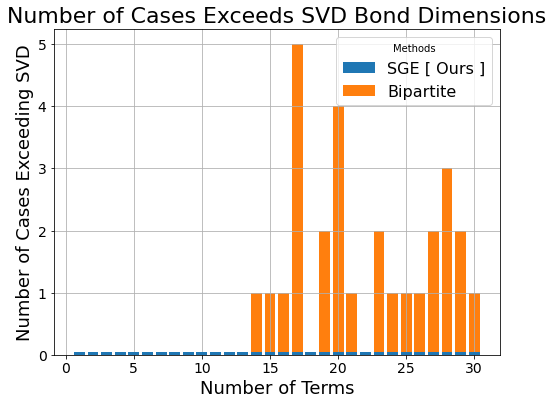

In [20]:
#plot_mean_bond_dimensions(file_path+file_name, save_path=file_path+"uniform_mean_bond_dims.pdf")
#compare_and_plot_bond_dimensions(file_path+file_name, save_path=file_path+"uniform_without_base_compare_bond_dims.pdf")
#highlight_differences(file_path+file_name, save_path=file_path+"uniform_without_base_highlight_differences.pdf")
#plot_average_bond_dimension_distribution(file_path+file_name, plot_type="box", save_path=file_path+"uniform_without_base_average_bond_dim_distribution.pdf")
#plot_cases_exceeding_svd_with_log_and_bar(file_path+file_name, save_path=file_path+"uniform_cases_exceeding_svd.pdf")
plot_cases_exceeding_svd(file_path+file_name, save_path=file_path+"uniform_without_base_cases_exceeding_svd.pdf")